<a href="https://colab.research.google.com/github/roesta07/Modeling-Likert-Scale/blob/main/Likert_scale_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import expit,logit,softmax
import pymc3 as pm
import arviz as az

In [9]:

#helper function
def normalize(array):
  return array/np.sum(array)

def cut_points(p):
  cum_p=np.cumsum(p)
  log_odds_cum_p=logit(cum_p[:-1]) ## not need to do it for the last
  return log_odds_cum_p ## for 6 you get one fro free as we know last one will be 1

def generate_cutpoints(n_samples):
  initial_cutpoints=np.zeros((n_samples,6))
  for i in range(n_samples):
    initial_dist=np.array([1,3,5,7,6,5,4]) # this when dep A is 0
    p_dist_norm=normalize(initial_dist)
    initial_cutpoints[i]=cut_points(p_dist_norm)
  return initial_cutpoints

def ordered_logistic_proba(a):
  p_dist_cum=expit(a)
  p_dist_cum=np.concatenate(([0.0],p_dist_cum,[1.0]))
  p_dist=p_dist_cum[1:]-p_dist_cum[:-1]
  return p_dist


In [10]:
d=stats.multinomial(1,[0.5,0.5]).rvs(2)
for dep in d:
  print(dep,dep[0])

[1 0] 1
[0 1] 0


In [11]:

def generate_data(n_samples=None,to_df=True):
  scales=[]
  bA=-2 ## our pressumed parameters
  depart=stats.multinomial(1,[0.5,0.5]).rvs(n_samples) # Split detart
  initial_cutpoints=generate_cutpoints(n_samples)
  for dep,cutpoint in zip(depart,initial_cutpoints):

    phi=bA*dep[0]
    
    p_dist_ods=cutpoint-phi
    #print(f'dep:{dep[0]},phi:{phi},p_distods{p_dist_ods}')
    p_dist=ordered_logistic_proba(p_dist_ods)
    scale=stats.multinomial(1,p_dist).rvs()
    scales.append(np.where(scale==1)[1][0])
  scales=np.array(scales)
  if to_df==True:
    df=pd.DataFrame(depart,columns=['depA','other_dep'])
    df['ratings']=scales
    return df
  else:
    return scales
    

In [12]:
df=pd.read_csv('https://raw.githubusercontent.com/roesta07/Modeling-Likert-Scale/main/data/data_likert.csv')
df.head()

,depA,other_dep,ratings
0,0,1,3
1,1,0,1
2,0,1,3
3,1,0,2
4,0,1,4


In [13]:
(df.depA==1).sum()

404

Text(0, 0.5, 'frequency')

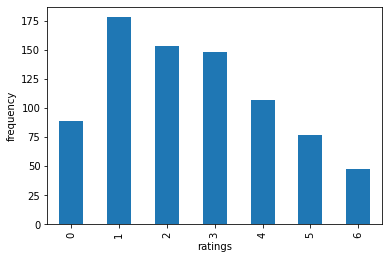

In [14]:

df.ratings.value_counts(sort=False).plot(kind='bar')
plt.xlabel('ratings')
plt.ylabel('frequency')

In [15]:
with pm.Model() as m_1:
  cutpoints = pm.Normal(
    "cutpoints",
    0.0,
    2,
    transform=pm.distributions.transforms.ordered,
    shape=6,
    testval=np.arange(6) - 2.5,
  )
  A=pm.intX(pm.Data('A',df.depA))

  bA=pm.Normal('bA',0,1)
  
  phi=pm.Deterministic('phi',bA*A)
  
  R = pm.OrderedLogistic("R", phi, cutpoints, observed=df.ratings)
  trace_1=pm.sample(cores=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bA, cutpoints]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8844011406623687, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
az.summary(trace_1,round_to=2,var_names=['~phi'])

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-1.94,0.14,-2.21,-1.68,0.0,0.0,1551.59,1229.26,1.0
cutpoints[0],-3.41,0.15,-3.71,-3.13,0.0,0.0,1192.14,1282.19,1.0
cutpoints[1],-1.85,0.12,-2.06,-1.62,0.0,0.0,1594.35,1524.80,1.0
cutpoints[2],-0.86,0.10,-1.05,-0.66,0.0,0.0,2000.63,1613.12,1.0
cutpoints[3],0.13,0.10,-0.04,0.31,0.0,0.0,2492.07,1924.70,1.0
cutpoints[4],1.02,0.11,0.84,1.23,0.0,0.0,2691.25,1753.70,1.0
cutpoints[5],2.16,0.16,1.88,2.47,0.0,0.0,3050.19,1570.25,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd44e335b50>,
      dtype=object)

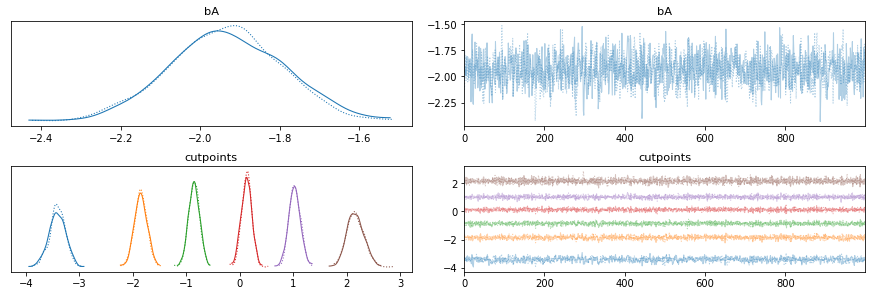

In [17]:
az.plot_trace(trace_1,var_names=['~phi'])

In [18]:
cut_points(ordered_logistic_proba(trace_1['cutpoints'][0]))

array([-3.47172537, -1.79154818, -0.80886502,  0.2135881 ,  0.9967959 ,
        2.08502619])

In [19]:
cases=np.array([0,1])
with m_1:
  pm.set_data({'A':cases})
  posterior_1=pm.sample_posterior_predictive(trace_1,var_names=["phi",'cutpoints','R'])
  pp_phi=posterior_1['phi']
  pp_cutpoints=posterior_1['cutpoints']
  pp_R=posterior_1['R']

In [20]:
pp_R

array([[2, 1],
       [3, 2],
       [2, 1],
       ...,
       [3, 2],
       [5, 1],
       [3, 3]])

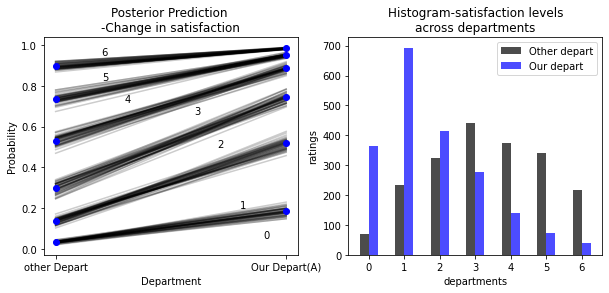

In [34]:
def ret_p(cutpoints,phi):
  ## return cumulative probability
  mu=cutpoints-phi
  p_dist_cum=expit(mu)
  p_dist_cum=np.concatenate(([0.0],p_dist_cum,[1.0]))
  #p_dist=p_dist_cum[1:]-p_dist_cum[:-1]

  return p_dist_cum[1:-1]

fig,axs=plt.subplots(1,2,figsize=(10,4))
for i in range(50):
  p_mu_0=ret_p(pp_cutpoints[i],pp_phi[:,0][i])
  p_mu_1=ret_p(pp_cutpoints[i],pp_phi[:,1][i])
  x=np.array((np.zeros(6),np.ones(6)))
  y=np.array((p_mu_0,p_mu_1))
  axs[0].plot(x,y,'k',alpha=0.2,)

p_mu_0_mean=ret_p(pp_cutpoints.mean(0),pp_phi[:,0].mean())
p_mu_1_mean=ret_p(pp_cutpoints.mean(0),pp_phi[:,1].mean())
axs[0].plot([np.zeros(6),np.ones(6)],[p_mu_0_mean,p_mu_1_mean],'ob')
  
axs[0].set(xticks=[0,1],ylabel='Probability',xlabel='Department',title='Posterior Prediction \n-Change in satisfaction')
axs[0].set_xticklabels(['other Depart','Our Depart(A)'])
##text

axs[0].annotate('0',(0.9,0.05))
axs[0].annotate('1',(0.8,0.2))
axs[0].annotate('2',(0.7,0.5))
axs[0].annotate('3',(0.6,0.66))
axs[0].annotate('4',(0.3,0.72))
axs[0].annotate('5',(0.2,0.83))
axs[0].annotate('6',(0.2,0.95))

## right hand-side plot
bins,colors=(
    np.arange(8)-0.5,
    ['k','b']
      )

axs[1].hist(
    [pp_R[:,0],pp_R[:,1]],
    bins=bins,
    rwidth=0.5,
    alpha=0.7,
    color=colors,
    histtype='bar',
    label=['Other depart','Our depart']
)
axs[1].set(title='Histogram-satisfaction levels\nacross departments', ylabel='ratings',xlabel='departments' )

axs[1].legend()
